<a href="https://www.kaggle.com/code/aletbm/blood-cell-cancer-prediction?scriptVersionId=215094148" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🩸 Blood Cell Cancer Prediction - Classification & Segmentation by [Alexander Daniel Rios](https://linktr.ee/aletbm)

<img src="https://i.postimg.cc/vZ0zy1WB/RCB-banner-0000.webp" width=1800px>

### Overview
Acute lymphocytic leukemia (ALL) is a type of cancer of the blood and bone marrow (the spongy tissue inside bones where blood cells are made).

Acute lymphocytic leukemia is the most common type of cancer in children, and treatments result in a good chance for a cure. Acute lymphocytic leukemia can also occur in adults, though the chance of a cure is greatly reduced.

### Causes
Acute lymphocytic leukemia occurs when a bone marrow cell develops changes (mutations) in its genetic material or DNA. A cell's DNA contains the instructions that tell a cell what to do. Normally, the DNA tells the cell to grow at a set rate and to die at a set time. In acute lymphocytic leukemia, the mutations tell the bone marrow cell to continue growing and dividing.

When this happens, blood cell production becomes out of control. The bone marrow produces immature cells that develop into leukemic white blood cells called lymphoblasts. These abnormal cells are unable to function properly, and they can build up and crowd out healthy cells.

### ALL Subtypes
Doctors classify acute lymphoblastic leukemia (ALL) into subtypes by using various tests. It's important to get an accurate diagnosis since your subtype plays a large part in deciding the type of treatment you'll receive. Depending on your ALL subtype, the doctor will determine

+ The type of drug combination needed for your treatment
+ The length of time you'll need to be in treatment
+ Other types of treatment that may be needed to achieve the best outcomes

Based on immunophenotyping of the leukemia cell, the World Health Organization (WHO) classifies ALL into two main subtypes.

+ **B-cell lymphoblastic leukemia/lymphoma**: This subtype begins in immature cells that would normally develop into B-cell lymphocytes. This is the most common ALL subtype. Among adults, B-cell lineage represents 75 percent of cases.
+ **T-cell lymphoblastic leukemia**: This subtype of ALL originates in immature cells that would normally develop into T-cell lymphocytes. This subtype is less common, and it occurs more often in adults than in children. Among adults, T-cell lineage represents about 25 percent of cases.

<img src="https://i.postimg.cc/Nf9YmT0h/Origin-of-different-subtypes-of-blood-cancer-red-with-respective-associated-cell-types.png" width=500px>

The final task of the lymphocytes (B cells) developed in the bone marrow (BM) is the production of antigen-specific immunoglobulins (IGS), which function as antibodies. IGS are proteins secreted by or present on the surface of B cells, assembled from identical pairs of heavy (H) and light (L) chains.

Antibody structure<br>
<img src="https://i.postimg.cc/J7gCrn5p/antibody-structure-figure-4.png" width=400px>


Before being capable of producing Ag-specific IGS, B cells must undergo a number of transformations, first in the BM and subsequently in the lymph nodes (LNs). The first stages of B-cell development occur in the BM, where pro-B cells first rearrange the Ig H chain gene to become pre-B cells. Pre-B cells continue this somatic recombination process by rearranging the L chain to become immature B cells, expressing IgM on their surface.

B-cell development<br>
<img src="https://i.postimg.cc/NMzSjJmK/3-s2-0-B9780123742797090196-f09019-01-9780123742797.jpg" width=600px>

### About the dataset

In this project I used the following dataset: [Blood cell cancer all 4 class](https://www.kaggle.com/datasets/mohammadamireshraghi/blood-cell-cancer-all-4class)

You can download this dataset with the following code:

```
!pip install kagglehub

import kagglehub
blood_cell_cancer_all_4class_path = kagglehub.dataset_download('mohammadamireshraghi/blood-cell-cancer-all-4class')
```

The images of this dataset were prepared in the bone marrow laboratory of Taleqani Hospital (Tehran, Iran).

This dataset consisted of **3242 PBS images** from 89 patients suspected of ALL, whose blood samples were prepared and stained by skilled laboratory staff. This dataset is divided into two classes *benign* and *malignant*. The former comprises hematogenous, and the latter is the ALL group with three subtypes of malignant lymphoblasts: **Early Pre-B**, **Pre-B**, and **Pro-B ALL**. 

All the images were taken by using a Zeiss camera in a microscope with a 100x magnification and saved as JPG files. A specialist using the flow cytometry tool made the definitive determination of the types and subtypes of these cells.

---
# Installing packages <a name="ip"></a>

In [1]:
!pip install mplcyberpunk

# Importing packages

In [70]:
import numpy as np
import pandas as pd
import os
import random

import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.backend import epsilon
from tensorflow.keras.utils import load_img
from tensorflow.data.experimental import cardinality
from tensorflow.image import (random_flip_left_right, 
                              random_flip_up_down,
                              random_brightness,
                              random_contrast,
                              random_jpeg_quality,
                              random_saturation,
                              resize)

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (Conv2D, 
                                     Dense,
                                     Dropout,
                                     Flatten,
                                     GlobalAveragePooling2D,
                                     MaxPooling2D,
                                     BatchNormalization,
                                     ReLU,
                                     Conv2DTranspose,
                                     Concatenate)

from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import CategoricalCrossentropy, Dice
from tensorflow.keras.metrics import AUC, BinaryIoU, BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix

import cv2

from IPython.display import clear_output

import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")

# Setting for reproducibility

In [3]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

---
# Gathering image pathfiles <a name="gip"></a>

In [4]:
imgs_path = []
classes = []

data_dir = "/kaggle/input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]"
for dirpath, dirnames, filenames in os.walk(data_dir):
    if len(classes) == 0:
        classes = dirnames
    for filename in filenames:
        imgs_path.append(os.path.join(dirpath, filename))

## From images metadata to Pandas DataFrame

In [5]:
def get_class(x):
    for class_ in classes:
        if class_ in x:
            return class_

df_imgs = pd.DataFrame(data=imgs_path, columns=["pathfiles"])
df_imgs["type_cell"] = df_imgs.map(get_class)

widths = []
heights = []
for row in df_imgs.iterrows():
    h, w = load_img(row[1].pathfiles).size
    widths.append(w)
    heights.append(h)

df_imgs["width"] = widths
df_imgs["heigth"] = heights

df_imgs

pathfiles  \
0     /kaggle/input/blood-cell-cancer-all-4class/Blo...   
1     /kaggle/input/blood-cell-cancer-all-4class/Blo...   
2     /kaggle/input/blood-cell-cancer-all-4class/Blo...   
3     /kaggle/input/blood-cell-cancer-all-4class/Blo...   
4     /kaggle/input/blood-cell-cancer-all-4class/Blo...   
...                                                 ...   
3237  /kaggle/input/blood-cell-cancer-all-4class/Blo...   
3238  /kaggle/input/blood-cell-cancer-all-4class/Blo...   
3239  /kaggle/input/blood-cell-cancer-all-4class/Blo...   
3240  /kaggle/input/blood-cell-cancer-all-4class/Blo...   
3241  /kaggle/input/blood-cell-cancer-all-4class/Blo...   

                    type_cell  width  heigth  
0     [Malignant] early Pre-B    768    1024  
1     [Malignant] early Pre-B    768    1024  
2     [Malignant] early Pre-B    768    1024  
3     [Malignant] early Pre-B    768    1024  
4     [Malignant] early Pre-B    768    1024  
...                       ...    ...     ...  
3237                   Benign    768    1024  
3238                   Benign    768    1024  
3239                   Benign    768    1024  
3240                   Benign   1920    2560  
3241                   Benign    768    1024  

[3242 rows x 4 columns]

## Setting for normalization of image sizes

In [6]:
df_imgs.width.value_counts()

width
768     3196
1920      46
Name: count, dtype: int64

Los factores comunes entre 768 y 1920 son [1, 2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192, 384], por tanto redimensionaremos estas images a 192

In [7]:
df_imgs.heigth.value_counts()

heigth
1024    3196
2560      46
Name: count, dtype: int64

Los factores comunes entre 1024 y 2560 son [1, 2, 4, 8, 16, 32, 64, 128, 256, 512], por tanto redimensionaremos estas images a 256

In [8]:
img_shape = (192, 256)

---

# EDA: Visualization of the image dataset 

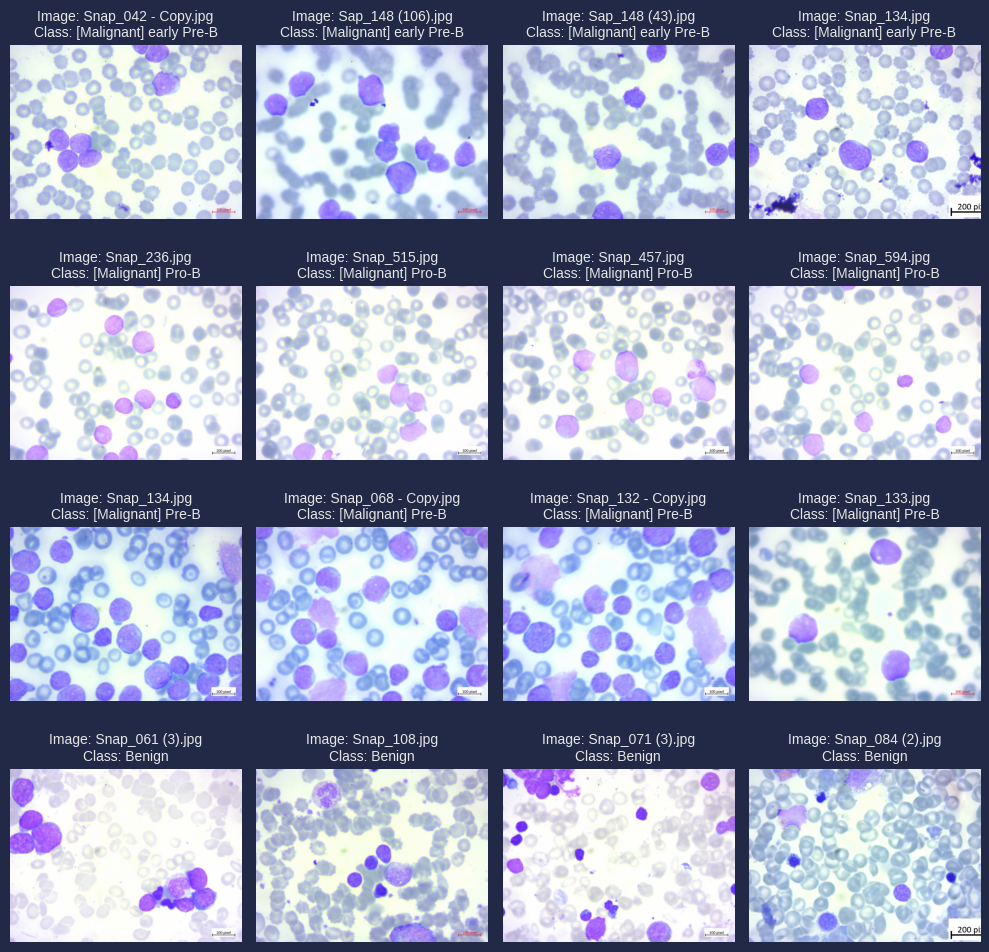

In [9]:
def random_img(df, cell=None, n=4):
    if cell:
        aux = df[df["type_cell"] == cell]
    else:
        aux = df
    return aux.loc[random.sample(list(aux.index), n)]

plt.subplots(4, 4, figsize=(10, 10))

for x, class_ in enumerate(classes):
    imgs = random_img(df_imgs, cell=class_, n=4)
    for i, row in enumerate(imgs.iterrows()):
        plt.subplot(4, 4, (x*4)+(i+1))
        plt.imshow(load_img(row[1].pathfiles))
        plt.title(f"Image: {row[1].pathfiles.split('/')[-1]}\nClass: {class_}", fontsize=10)
        plt.axis("off")
plt.tight_layout()

---
# Extract the masks from the images

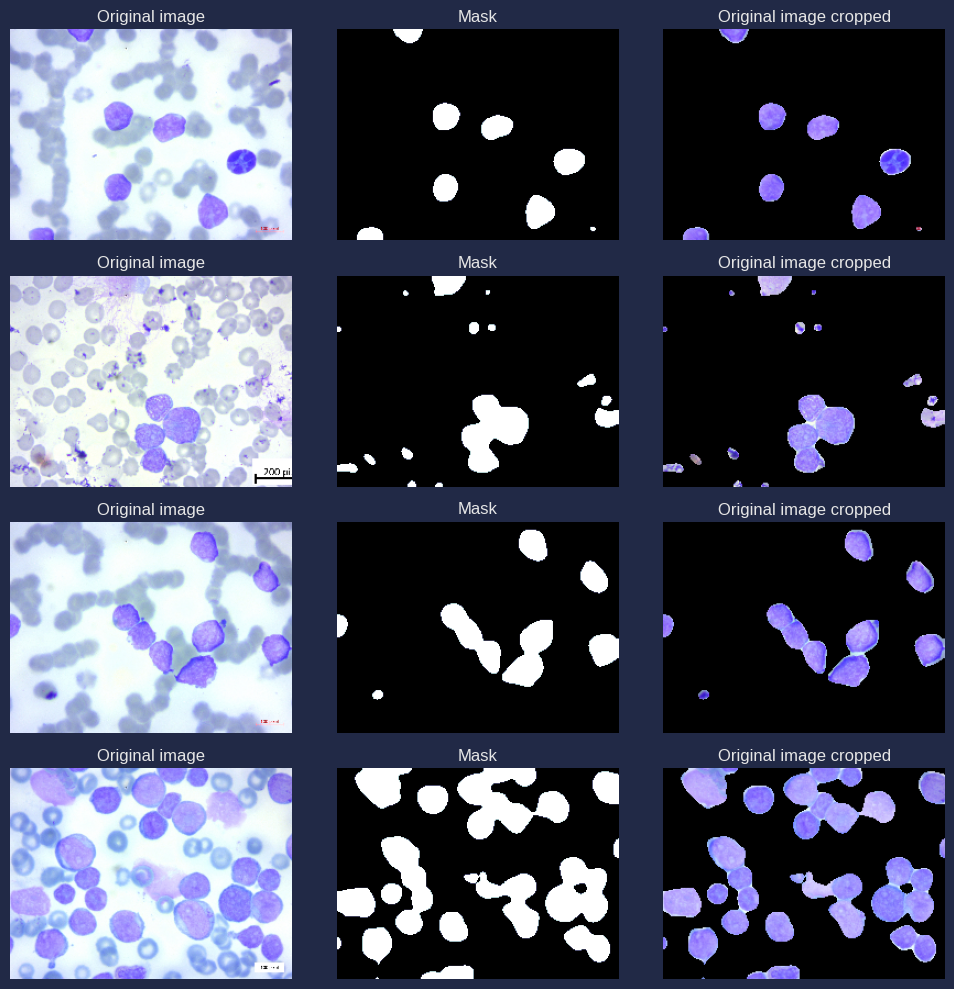

In [10]:
def get_image(pathfile):
    return cv2.cvtColor(cv2.imread(pathfile), cv2.COLOR_BGR2RGB)

def RGB2LAB(image):
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(image_lab)
    return l, a, b

def get_mask(image):
    l, a, b = RGB2LAB(image)
    a_blur = cv2.GaussianBlur(a, (19, 19), 0)
    _, thresh_img = cv2.threshold(a_blur, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = np.ones((1, 1),np.uint8) 
    return cv2.morphologyEx(thresh_img, op=cv2.MORPH_CLOSE, kernel=kernel, iterations=1)

def apply_mask(image, mask):
    return cv2.bitwise_and(image, image, mask=mask)
    
plt.subplots(4, 3, figsize=(10, 10))
imgs = random_img(df_imgs, n=4)

for i, row in enumerate(imgs.iterrows()):
    # Read image
    image = get_image(pathfile=row[1].pathfiles)
    image = resize(image, size=img_shape, method="nearest", antialias=True).numpy()
    mask = get_mask(image)
    image_cropped = apply_mask(image, mask)
    
    plt.subplot(4, 3, (i*3)+1)
    plt.imshow(image)
    plt.axis("off")
    plt.title("Original image")
    
    plt.subplot(4, 3, (i*3)+2)
    plt.imshow(mask, cmap="bone")
    plt.axis("off")
    plt.title("Mask")
    
    plt.subplot(4, 3, (i*3)+3)
    plt.imshow(image_cropped)
    plt.axis("off")
    plt.title("Original image cropped");

plt.tight_layout()
plt.show()

---
# Creating training, validation and testing image set

In [11]:
df_full_train, df_test = train_test_split(df_imgs, test_size=0.15, stratify=df_imgs.type_cell, shuffle=True, random_state=seed_value)
df_train, df_val = train_test_split(df_full_train, test_size=1-(7/8.5), stratify=df_full_train.type_cell, shuffle=True, random_state=seed_value)

## Creating TFRecord files for contain our data

In [12]:
def createTFRecord(pathfile, dataset, size_img):
    #options = tf.io.TFRecordOptions(compression_type="GZIP", compression_level=9)
    writer = tf.io.TFRecordWriter(pathfile,
                                  #options=options
                                 )
    cnt_written_img = 0
    for index, row in dataset.iterrows():
        image = get_image(row.pathfiles)
        image = resize(image, size=img_shape, method="nearest", antialias=True).numpy()
        mask = np.array(get_mask(image))

        class_ = np.argmax(np.array(classes) == row.type_cell)
        image_data, mask_data = image.tobytes(), mask.tobytes()
        
        example = tf.train.Example(features=tf.train.Features(feature={
            'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_data])),
            'mask': tf.train.Feature(bytes_list=tf.train.BytesList(value=[mask_data])),
            'class': tf.train.Feature(int64_list=tf.train.Int64List(value=[class_])),
        }))

        writer.write(example.SerializeToString())
        cnt_written_img += 1
    return cnt_written_img

def parse(feature):
    features = tf.io.parse_single_example(
        feature,
        features={
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
        'class': tf.io.VarLenFeature(tf.int64),
    })
    image = tf.reshape(tf.io.decode_raw(features['image'], out_type=tf.uint8), shape=(img_shape[0], img_shape[1], 3))
    mask = tf.reshape(tf.io.decode_raw(features['mask'], out_type=tf.uint8), shape=(img_shape[0], img_shape[1], 1))
    class_ = tf.sparse.to_dense(features["class"])
    return image, mask, class_

autotune = tf.data.AUTOTUNE
create_tensorflow_record = True
DIR_TFRECORD = "/kaggle/working/blood_cell_cancer_with_mask"

if create_tensorflow_record == True:
    createTFRecord(pathfile=DIR_TFRECORD+"_train.tfrecord", dataset=df_train, size_img=img_shape)
    createTFRecord(pathfile=DIR_TFRECORD+"_val.tfrecord", dataset=df_val, size_img=img_shape)
    createTFRecord(pathfile=DIR_TFRECORD+"_test.tfrecord", dataset=df_test, size_img=img_shape)
    
train_data = tf.data.TFRecordDataset(DIR_TFRECORD+"_train.tfrecord")
train_data = train_data.map(parse, num_parallel_calls=autotune)

val_data = tf.data.TFRecordDataset(DIR_TFRECORD+"_val.tfrecord")
val_data = val_data.map(parse, num_parallel_calls=autotune)

test_data = tf.data.TFRecordDataset(DIR_TFRECORD+"_test.tfrecord")
test_data = test_data.map(parse, num_parallel_calls=autotune)

### Let's take a preview

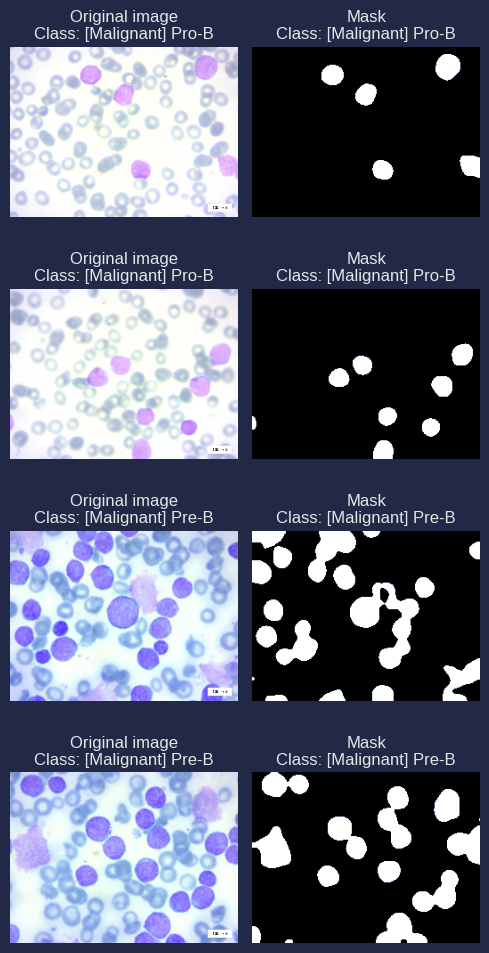

In [13]:
plt.subplots(4, 2, figsize=(5, 10))
for i, data in enumerate(train_data.take(4)):
    plt.subplot(4, 2, (i*2)+1)
    plt.imshow(data[0])
    plt.axis("off")
    plt.title(f"Original image\nClass: {classes[data[2][0]]}")
    plt.subplot(4, 2, (i*2)+2)
    plt.imshow(data[1], cmap="bone")
    plt.axis("off")
    plt.title(f"Mask\nClass: {classes[data[2][0]]}")
plt.tight_layout()

## Loading the images for image classification

In [14]:
batch_size = 32

def classification_task(image, mask, class_):
    class_ohe = tf.one_hot(indices=tf.squeeze(class_, axis=0), depth=4)
    return tf.cast(image, dtype=tf.float32)/255, tf.cast(class_ohe, dtype=tf.float32)

train_data_clf = train_data.map(classification_task, num_parallel_calls=autotune)
train_data_clf = train_data_clf.batch(batch_size)
train_data_clf = train_data_clf.prefetch(autotune)

val_data_clf = val_data.map(classification_task, num_parallel_calls=autotune)
val_data_clf = val_data_clf.batch(batch_size)
val_data_clf = val_data_clf.prefetch(autotune)

test_data_clf = test_data.map(classification_task, num_parallel_calls=autotune)
test_data_clf = test_data_clf.batch(batch_size)
test_data_clf = test_data_clf.prefetch(autotune)

## Loading the images for image segmentation

In [15]:
def segmentation_task(image, mask, class_):
    return tf.cast(image, dtype=tf.float32)/255, tf.cast(mask, dtype=tf.float32)/255

train_data_sg = train_data.map(segmentation_task, num_parallel_calls=autotune)
train_data_sg = train_data_sg.batch(batch_size)
train_data_sg = train_data_sg.prefetch(autotune)

val_data_sg = val_data.map(segmentation_task, num_parallel_calls=autotune)
val_data_sg = val_data_sg.batch(batch_size)
val_data_sg = val_data_sg.prefetch(autotune)

test_data_sg = test_data.map(segmentation_task, num_parallel_calls=autotune)
test_data_sg = test_data_sg.batch(batch_size)
test_data_sg = test_data_sg.prefetch(autotune)

## Loading the images for both tasks

In [16]:
def both_task(image, mask, class_):
    class_ohe = tf.one_hot(indices=tf.squeeze(class_, axis=0), depth=4)
    return tf.cast(image, dtype=tf.float32)/255, {"segmentation": tf.cast(mask, dtype=tf.float32)/255, "classification": tf.cast(class_ohe, dtype=tf.float32)}

train_data_both = train_data.map(both_task, num_parallel_calls=autotune)
train_data_both = train_data_both.batch(batch_size)
train_data_both = train_data_both.prefetch(autotune)

val_data_both = val_data.map(both_task, num_parallel_calls=autotune)
val_data_both = val_data_both.batch(batch_size)
val_data_both = val_data_both.prefetch(autotune)

test_data_both = test_data.map(both_task, num_parallel_calls=autotune)
test_data_both = test_data_both.batch(batch_size)
test_data_both = test_data_both.prefetch(autotune)

## Training image visualization

### For classification

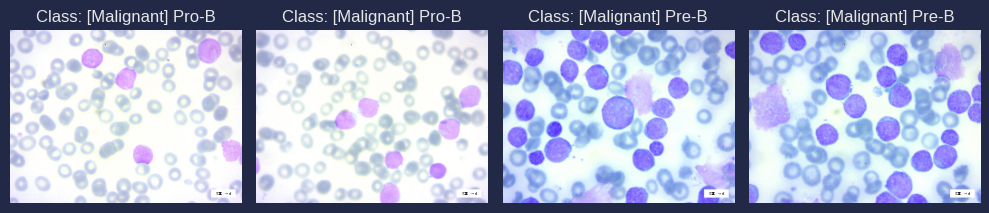

In [17]:
plt.subplots(1, 4, figsize=(10, 4))
for i, (image, class_ohe) in enumerate(train_data_clf.take(1).unbatch()):
    if i == 4:
        break
    plt.subplot(1, 4, i+1)
    plt.imshow(tf.cast(image*255, tf.uint8))
    plt.title(f"Class: {classes[np.argmax(class_ohe)]}")
    plt.axis("off")
plt.tight_layout()

### For segmentation

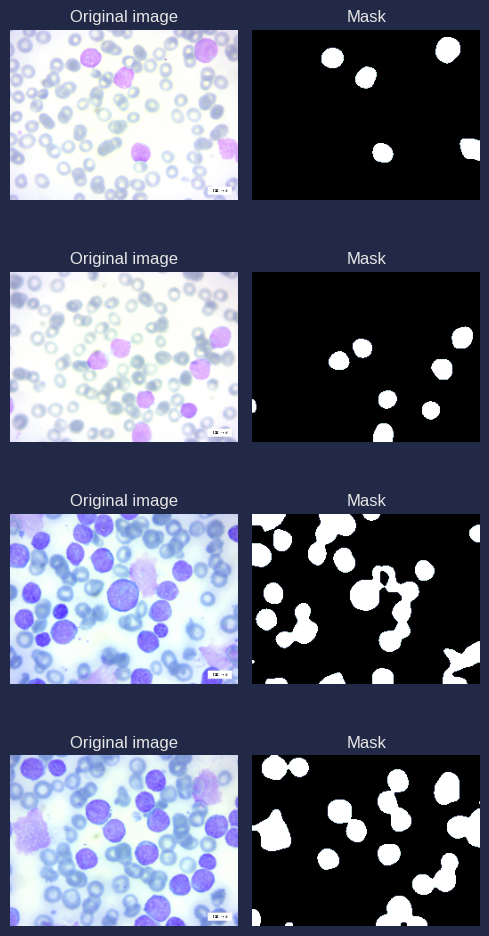

In [18]:
plt.subplots(4, 2, figsize=(5, 10))
for i, (image, mask) in enumerate(train_data_sg.take(1).unbatch()):
    if i == 4:
        break
    plt.subplot(4, 2, (i*2)+1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Original image")
    plt.subplot(4, 2, (i*2)+2)
    plt.imshow(mask, cmap="bone")
    plt.axis("off")
    plt.title(f"Mask")
plt.tight_layout()

---
# Handling imbalance image dataset

## Calculating the class weights for the classes

In [19]:
df_train.type_cell.value_counts()

type_cell
[Malignant] early Pre-B    685
[Malignant] Pre-B          668
[Malignant] Pro-B          557
Benign                     358
Name: count, dtype: int64

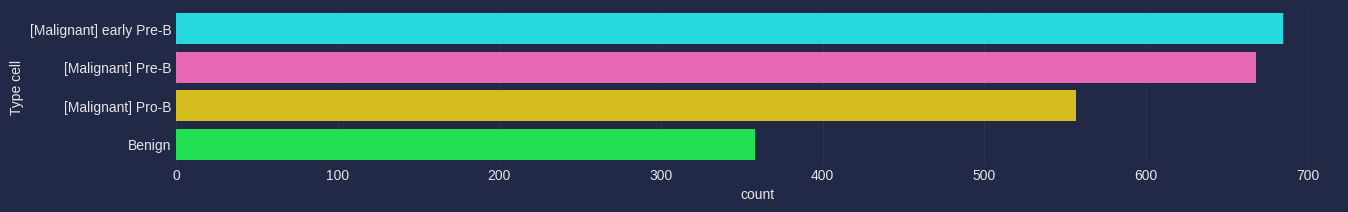

In [20]:
import seaborn as sns
plt.figure(figsize=(15, 2))
sns.countplot(df_train, y="type_cell", alpha=1, order=df_train.type_cell.value_counts().sort_values(ascending=False).index.values)
plt.ylabel("Type cell");

In [21]:
class_weight = dict(zip([i for i, _ in enumerate(classes)], compute_class_weight(class_weight="balanced", classes=classes, y=df_train.type_cell)))
class_weight

{0: 0.8277372262773722,
 1: 1.0179533213644525,
 2: 0.8488023952095808,
 3: 1.5837988826815643}

## Calculating the class weights for the masks

In [22]:
pixels_one = 0
pixels_zero = 0

for image, mask, class_ in train_data:
    aux = tf.reduce_sum(mask/255)
    pixels_one += aux
    pixels_zero += (mask.shape[0] * mask.shape[1]) - aux
    
total_pixels = pixels_one + pixels_zero
print(pixels_one, pixels_zero, total_pixels)

tf.Tensor(12867587.0, shape=(), dtype=float32) tf.Tensor(98609190.0, shape=(), dtype=float32) tf.Tensor(111476776.0, shape=(), dtype=float32)


In [23]:
class_weight_pixel = {0:(total_pixels/(2*pixels_zero)).numpy(), 1:(total_pixels/(2*pixels_one)).numpy()}
class_weight_pixel

{0: 0.56524533, 1: 4.3316894}

---
# Diagnosing Acute Lymphoblastic Leukemia (ALL) by classifying and segmenting images of blood cells affected by cancer

# Image classification

## Creating a baseline model for image classification

In [24]:
def conv2d(filters):
    return Conv2D(filters, kernel_size=(2, 2), padding='same', strides=(1, 1), data_format="channels_last", kernel_initializer='he_normal', kernel_regularizer=L2(l2=1e-5))

def block_conv(inp, filters=128, dropout=0.4):
    x = conv2d(filters)(inp)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    
    x = conv2d(filters//2)(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    
    x = MaxPooling2D(pool_size=(2, 2))(x)
    return Dropout(dropout)(x)

def classification_base_architecture(inp, name_output=None):
    x = block_conv(inp, filters=128, dropout=0.4)
    x = block_conv(x, filters=128, dropout=0.4)
    
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(32, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(len(classes), activation="softmax", name=name_output)(x)
    return x


def get_model():
    tf.keras.backend.clear_session()
    
    inp = Input(shape=img_shape+(3,))
    x = classification_base_architecture(inp)
    model = Model(inputs=inp, outputs=x)
    
    model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=1e-3), metrics=[AUC()])
    return model

model_base = get_model()

In [25]:
model_base.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 192, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 192, 256, 128)       │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 192, 256, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 192, 256, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 192, 256, 64)        │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 192, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 192, 256, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 96, 128, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 96, 128, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 96, 128, 128)        │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 96, 128, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 96, 128, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 96, 128, 64)         │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 96, 128, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 96, 128, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 48, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │              

 Total params: 104,436 (407.95 KB)

 Trainable params: 103,668 (404.95 KB)

 Non-trainable params: 768 (3.00 KB)

### Let's train

In [26]:
def train_model(model, train_data, val_data, epochs=100, version="base"):
    checkpoint_filepath = f'/kaggle/working/models/model_{version}.keras'
    checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', save_best_only=True)
    early = EarlyStopping(monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
    reduce = ReduceLROnPlateau(monitor='val_loss', patience=3)
    csvlogger = CSVLogger(f"/kaggle/working/histories/history_model_{version}.csv", separator=',')
    
    history = model.fit(train_data,
                      batch_size=batch_size,
                      epochs=epochs,
                      callbacks=[early,
                                 reduce,
                                 checkpoint,
                                 csvlogger],
                      validation_data=val_data,
                      class_weight=class_weight,
                      steps_per_epoch=len(df_train)//batch_size,
                      validation_steps=len(df_val)//batch_size,
                      validation_batch_size=batch_size
                     )
    return history

In [27]:
history_base = train_model(model_base, train_data_clf, val_data_clf, epochs=1000, version="base")

Epoch 1/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 176ms/step - auc: 0.9112 - loss: 0.7039 - val_auc: 0.6331 - val_loss: 1.6579 - learning_rate: 0.0010
Epoch 2/1000
 1/70 ━━━━━━━━━━━━━━━━━━━━ 9:50 9s/step - auc: 0.9979 - loss: 0.1629

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - auc: 0.9979 - loss: 0.1629 - val_auc: 0.7925 - val_loss: 1.1231 - learning_rate: 0.0010
Epoch 3/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - auc: 0.9939 - loss: 0.2004 - val_auc: 0.6938 - val_loss: 3.1847 - learning_rate: 0.0010
Epoch 4/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - auc: 0.9996 - loss: 0.0892 - val_auc: 0.8605 - val_loss: 1.5479 - learning_rate: 0.0010
Epoch 5/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - auc: 0.9983 - loss: 0.1121 - val_auc: 0.6196 - val_loss: 4.5441 - learning_rate: 0.0010
Epoch 6/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - auc: 0.9996 - loss: 0.0458 - val_auc: 0.8095 - val_loss: 2.2067 - learning_rate: 1.0000e-04
Epoch 7/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - auc: 0.9993 - loss: 0.0708 - val_auc: 0.7663 - val_loss: 2.6162 - learning_rate: 1.0000e-04
Epoch 8/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - auc: 1.0000 - loss: 0.0261 - val_auc: 0.8980 - val_loss: 1.5360 - learning_rate: 1.00

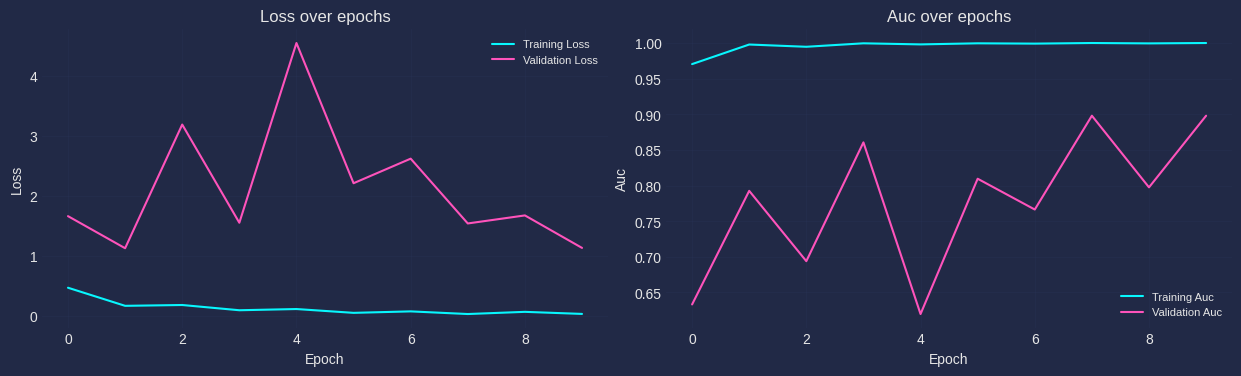

In [28]:
def delete_empty_subplots(fig, axs):
    for ax_row in axs:
        for ax in ax_row:
            if ax.title.get_text() == "":
                fig.delaxes(ax)
    return fig, axs

def show_history(version, parameters=None):
    df_hist = pd.read_csv(f"/kaggle/working/histories/history_model_{version}.csv")
    fig, axs = plt.subplots(2, 4, figsize=(25, 7))

    for i, col in enumerate(parameters):
        plt.subplot(2, 4, i+1)
        param = col[0].replace('_', ' ').title()
        plt.plot(df_hist.index, df_hist[col[0]], label=f"Training {param}")
        plt.plot(df_hist.index, df_hist[col[1]], label=f"Validation {param}")
        plt.ylabel(col[0].capitalize().replace("_", " "))
        plt.xlabel("Epoch")
        plt.legend(fontsize=8)
        plt.grid(True, alpha=0.3, which="both")
        plt.title(f"{param} over epochs")

    fig, axs = delete_empty_subplots(fig, axs)
    plt.tight_layout()
    plt.show()
    return
    
show_history(version="base", parameters=[["loss", "val_loss"],["auc", "val_auc"]])

## Evaluating the baseline model for image classification

In [29]:
model_base.evaluate(test_data_clf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.6246 - loss: 1.6760


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


[1.6554940938949585, 0.633040189743042]

## Applying data augmentation technique on images

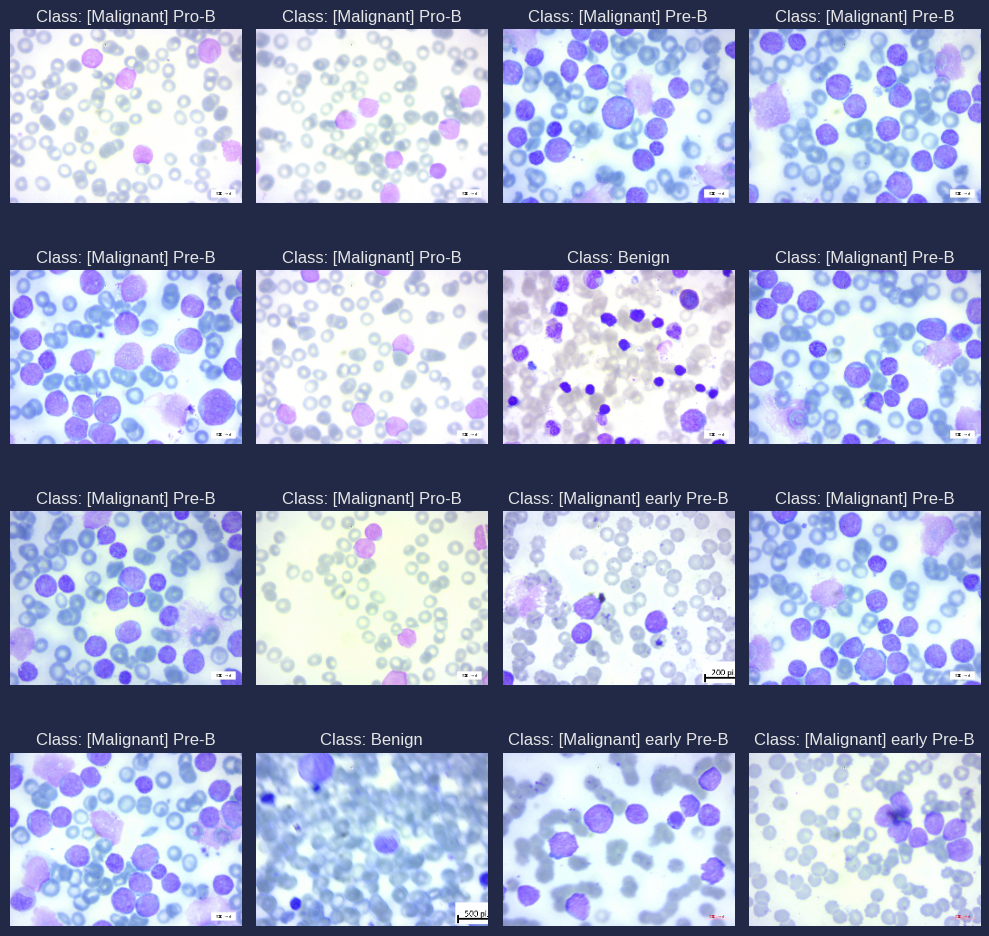

In [30]:
def data_augmentation(image, mask, class_):
    img = random_flip_left_right(image, seed=seed_value)
    img = random_flip_up_down(img, seed=seed_value)
    img = random_brightness(img, max_delta=0.01, seed=seed_value)
    img = random_contrast(img, lower=0.5, upper=1, seed=seed_value)
    img = random_saturation(img, lower=0.5, upper=1, seed=seed_value)
    class_ohe = tf.one_hot(indices=tf.squeeze(class_, axis=0), depth=4)
    return tf.cast(image, dtype=tf.float32)/255, tf.cast(class_ohe, dtype=tf.float32)

train_data_clf_aug = train_data.map(data_augmentation, num_parallel_calls=autotune)
train_data_clf_aug = train_data_clf_aug.batch(batch_size)
train_data_clf_aug = train_data_clf_aug.prefetch(autotune)

plt.subplots(4, 4, figsize=(10, 10))
for i, (image, class_ohe) in enumerate(train_data_clf_aug.take(1).unbatch()):
    if i == 16:
        break
    plt.subplot(4, 4, i+1)
    plt.imshow(tf.cast(image*255, tf.uint8))
    plt.title(f"Class: {classes[np.argmax(class_ohe)]}")
    plt.axis("off")
plt.tight_layout()

## Training a baseline model with data augmentation

In [31]:
model_base_aug = get_model()
history_base_aug = train_model(model_base_aug, train_data_clf_aug, val_data_clf, epochs=1000, version="base_aug")

Epoch 1/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - auc: 0.8881 - loss: 0.8142 - val_auc: 0.5600 - val_loss: 1.5864 - learning_rate: 0.0010
Epoch 2/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - auc: 0.9962 - loss: 0.2153 - val_auc: 0.8844 - val_loss: 1.0492 - learning_rate: 0.0010
Epoch 3/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - auc: 0.9931 - loss: 0.2388 - val_auc: 0.5284 - val_loss: 2.0281 - learning_rate: 0.0010
Epoch 4/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - auc: 1.0000 - loss: 0.0545 - val_auc: 0.4048 - val_loss: 2.4068 - learning_rate: 0.0010
Epoch 5/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - auc: 0.9969 - loss: 0.1359 - val_auc: 0.6945 - val_loss: 2.0005 - learning_rate: 0.0010
Epoch 6/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - auc: 1.0000 - loss: 0.0410 - val_auc: 0.2687 - val_loss: 3.5562 - learning_rate: 1.0000e-04
Epoch 7/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - auc: 0.9990 - loss: 0.0933 - val_auc: 0.8285 - val_loss: 1.0681 - learning_r

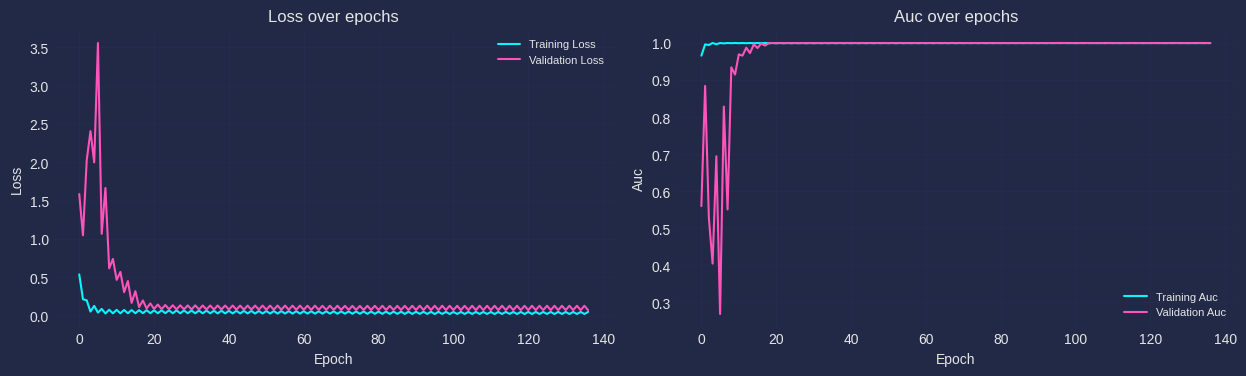

In [32]:
show_history(version="base_aug", parameters=[["loss", "val_loss"],["auc", "val_auc"]])

## Evaluating the baseline model with data augmentation

In [33]:
model_base_aug.evaluate(test_data_clf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9994 - loss: 0.0650


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


[0.07903992384672165, 0.9988158941268921]

## Transfer learning using the architecture proposed by the Visual Geometry Group (VGG)
<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*NNifzsJ7tD2kAfBXt3AzEg.png" width=600px>

In [34]:
def get_backbone():
    backbone = VGG16(include_top=False, weights='imagenet', input_shape=img_shape+(3,), pooling="avg")
    backbone.trainable = False
    return backbone

def classification_w_backbone_architecture(inp, name_output=None):
    backbone = get_backbone()
    x = backbone(inp, training=False)
    x = Flatten()(x)
    x = Dense(32, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(len(classes), activation="softmax", name=name_output)(x)
    return x

def get_model_w_backbone():
    tf.keras.backend.clear_session()
    
    inp = Input(shape=img_shape+(3,))
    x = classification_w_backbone_architecture(inp)
    model = Model(inputs=inp, outputs=x)
    
    model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=1e-3), metrics=[AUC()])
    return model

model_backbone = get_model_w_backbone()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


### Let's train

In [35]:
history_backbone = train_model(model_backbone, train_data_clf_aug, val_data_clf, epochs=100, version="backbone")

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - auc: 0.6693 - loss: 1.3361 - val_auc: 0.9185 - val_loss: 0.9439 - learning_rate: 0.0010
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - auc: 0.9141 - loss: 0.9127 - val_auc: 0.9116 - val_loss: 0.9718 - learning_rate: 0.0010
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - auc: 0.9442 - loss: 0.8705 - val_auc: 0.9750 - val_loss: 0.5699 - learning_rate: 0.0010
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc: 0.9902 - loss: 0.5167 - val_auc: 0.9796 - val_loss: 0.5395 - learning_rate: 0.0010
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - auc: 0.9769 - loss: 0.5649 - val_auc: 0.9831 - val_loss: 0.4041 - learning_rate: 0.0010
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc: 0.9966 - loss: 0.3432 - val_auc: 0.9864 - val_loss: 0.3492 - learning_rate: 0.0010
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - auc: 0.9842 - loss: 0.4180 - val_auc: 0.9886 - val_loss: 0.3115 - learning_rate: 0.0010
Epoch 

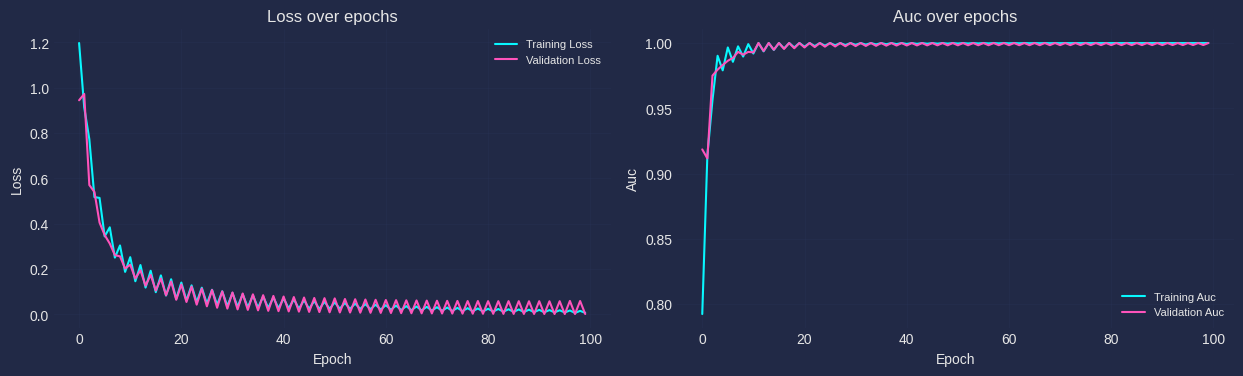

In [36]:
show_history(version="backbone", parameters=[["loss", "val_loss"],["auc", "val_auc"]])

## Evaluating the model with a VGG backbone

In [37]:
model_backbone.evaluate(test_data_clf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - auc: 0.9996 - loss: 0.0451


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


[0.04968789964914322, 0.9995390772819519]

## Evaluation metrics for classification task

In [38]:
def get_scores(y_true, y_pred, y_pred_proba):
    return {'AUC_ROC':roc_auc_score(y_true, y_pred_proba, multi_class='ovr'),
           'F1_Score':f1_score(y_true, y_pred, average='weighted'),
           'Accuracy':accuracy_score(y_true, y_pred),
           'Precision':precision_score(y_true, y_pred, average='weighted'),
           'Recall':recall_score(y_true, y_pred, average='weighted')}

for i, (img, class_) in enumerate(test_data_clf):
    if i == 0:
        y_true = class_.numpy()
    else:
        y_true = np.concatenate((y_true, class_.numpy()), axis=0)

scores = []
for model in [model_base, model_base_aug, model_backbone]:
    y_test_pred_proba = model.predict(test_data_clf, verbose=0)
    y_test_pred = tf.math.round(y_test_pred_proba)
    scores.append(get_scores(y_true, y_test_pred, y_test_pred_proba))

comparison = pd.DataFrame(data=scores, index=["Baseline Model", "Baseline Model with DA", "Model with VGG16"], columns=["AUC_ROC", "F1_Score", "Accuracy", "Precision", "Recall"])
comparison.style.highlight_max(color = 'green', axis = 0).highlight_min(color = 'red', axis = 0)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


---
# Image segmentation
## Creating a baseline model for image segmentation

In [39]:
def encoder(inp, filters):
    x1 = block_conv(inp, filters=filters, dropout=0.4)
    x2 = block_conv(x1, filters=filters, dropout=0.4)
    return x1, x2

def bottleneck(inp, filters):
    x = conv2d(filters)(inp)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    
    x = conv2d(filters)(inp)
    x = ReLU()(x)
    return BatchNormalization()(x)
    
def conv2dtranspose(filters):
        return Conv2DTranspose(filters=filters, activation="relu", kernel_size=(2, 2), strides=(2, 2), data_format="channels_last", kernel_initializer='he_normal', kernel_regularizer=L2(l2=1e-5))

def up_block(inp, output_enc, filters, dropout=0.4):
    x = conv2d(filters)(inp)
    x = Concatenate()([inp, output_enc])
    x = ReLU()(x)
    x = BatchNormalization()(x)
    
    x = conv2d(filters)(inp)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    
    x = conv2dtranspose(filters)(x)
    return Dropout(dropout)(x)
    
def decoder(inp, ouput_block1_enc, ouput_block2_enc, filters):
    x1 = up_block(inp, ouput_block2_enc, filters, dropout=0.4)
    x2 = up_block(x1, ouput_block1_enc, filters, dropout=0.4)
    return x2

def segmentation_architecture(inp, name_output=None):
    ouput_block1_enc, ouput_block2_enc = encoder(inp, filters=128)
    x = bottleneck(ouput_block2_enc, filters=128)
    x = decoder(x, ouput_block1_enc, ouput_block2_enc, filters=128)
    x = Conv2D(filters=1, activation="sigmoid", kernel_size=(2, 2), padding='same', strides=(1, 1), data_format="channels_last", kernel_initializer='he_normal', kernel_regularizer=L2(l2=1e-5), name=name_output)(x)
    return x

def get_model_segmentation():
    tf.keras.backend.clear_session()
    
    inp = Input(shape=img_shape+(3,))
    x = segmentation_architecture(inp)
    model = Model(inputs=inp, outputs=x)
    
    model.compile(loss=Dice(),
                  optimizer=Adam(learning_rate=1e-3),
                  metrics=[BinaryIoU(), BinaryAccuracy()])
    return model

model_base_sg = get_model_segmentation()

In [40]:
model_base_sg.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 192, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 192, 256, 128)       │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 192, 256, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 192, 256, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 192, 256, 64)        │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 192, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 192, 256, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 96, 128, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 96, 128, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 96, 128, 128)        │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 96, 128, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 96, 128, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 96, 128, 64)         │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 96, 128, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 96, 128, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 48, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 48, 64, 128)         │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 48, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 399,361 (1.52 MB)

 Trainable params: 397,825 (1.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [41]:
def show_predictions(dataset=None):
    for image, _ in dataset.shuffle(100).take(1):
        pred = model_base_sg.predict(image)
        pred_mask = pred[0] >= 0.5
        plt.subplots(1, 2, figsize=(6, 3))
        
        plt.subplot(1, 2, 1)
        plt.imshow(image[0])
        plt.axis("off")
        plt.title(f"Original image")
        
        plt.subplot(1, 2, 2)
        plt.imshow(pred_mask, cmap="bone")
        plt.axis("off")
        plt.title(f"Mask")
        
        plt.tight_layout()
        plt.show()
        break
    return

class DisplayCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(dataset=val_data_sg)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
        return

### Let's train

In [42]:
def train_model_segmentation(model, train_data, val_data, epochs=100, version="base"):
    checkpoint_filepath = f'/kaggle/working/models/model_{version}.keras'
    checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', save_best_only=True)
    early = EarlyStopping(monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
    reduce = ReduceLROnPlateau(monitor='val_loss', patience=3)
    csvlogger = CSVLogger(f"/kaggle/working/histories/history_model_{version}.csv", separator=',')
    
    history = model.fit(train_data,
                      batch_size=batch_size,
                      epochs=epochs,
                      callbacks=[early,
                                 reduce,
                                 checkpoint,
                                 csvlogger,
                                 DisplayCallback()],
                      validation_data=val_data,
                      class_weight=class_weight_pixel,
                      steps_per_epoch=len(df_train)//batch_size,
                      validation_steps=len(df_val)//batch_size,
                      validation_batch_size=batch_size
                     )
    return history

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


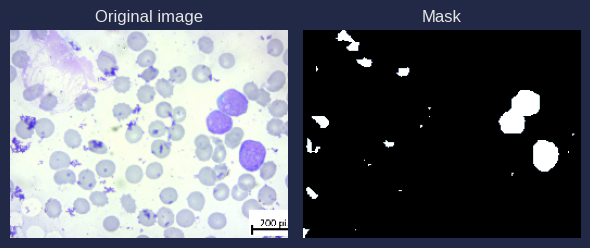


Sample Prediction after epoch 61

70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 267ms/step - binary_accuracy: 0.9849 - binary_io_u: 0.9138 - loss: 0.0849 - val_binary_accuracy: 0.9873 - val_binary_io_u: 0.9375 - val_loss: 0.0755 - learning_rate: 1.0000e-13
Epoch 61: early stopping
Restoring model weights from the end of the best epoch: 53.


In [43]:
history_base_sg = train_model_segmentation(model_base_sg, train_data_sg, val_data_sg, epochs=100, version="base_segmentation")

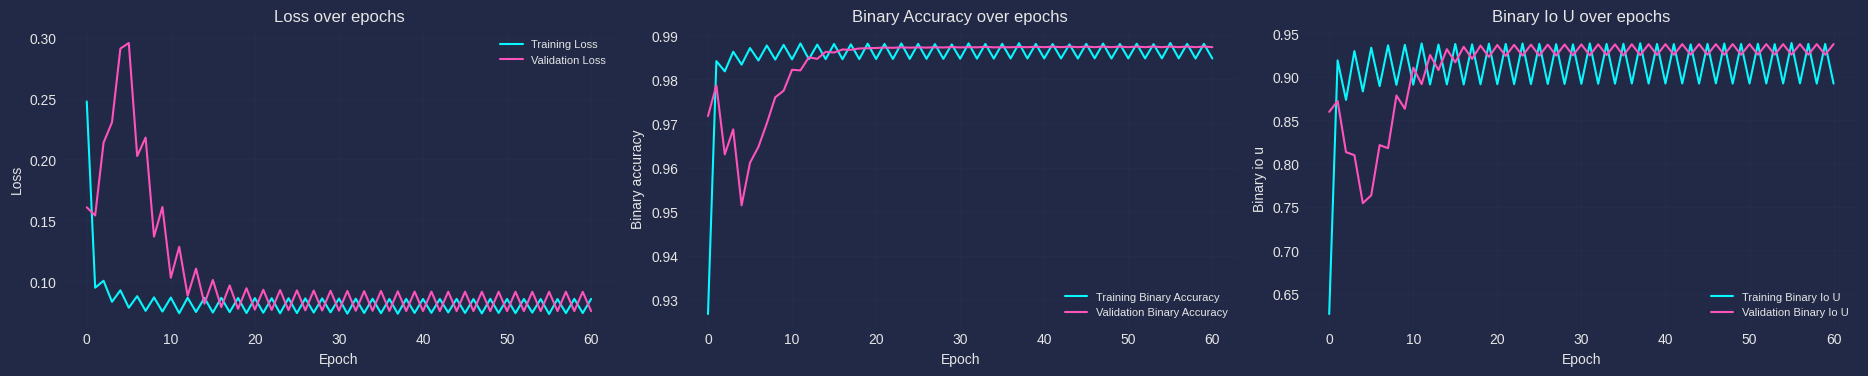

In [44]:
show_history(version="base_segmentation", parameters=[["loss", "val_loss"],
                                                      ["binary_accuracy", "val_binary_accuracy"],
                                                      ["binary_io_u", "val_binary_io_u"]])

## Evaluating the baseline model for segmentation

In [45]:
result_test_sg = model_base_sg.evaluate(test_data_sg)
result_test_sg

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - binary_accuracy: 0.9851 - binary_io_u: 0.9295 - loss: 0.0845


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


[0.08605244755744934, 0.9265046119689941, 0.9849827885627747]

model_base_sg = tf.keras.models.load_model("/kaggle/working/models/model_base_segmentation.keras")

## Applying data augmentation technique on images and masks

In [46]:
def data_transformation(image, mask, class_):
    img = random_brightness(image, max_delta=0.01, seed=seed_value)
    img = random_contrast(img, lower=0.5, upper=1, seed=seed_value)
    img = random_saturation(img, lower=0.5, upper=1, seed=seed_value)
    aux = tf.concat([img, mask], -1)
    
    aux_ = random_flip_left_right(aux, seed=seed_value)
    aux_ = random_flip_up_down(aux_, seed=seed_value)

    return tf.cast(aux_[..., :3], tf.float32)/255, tf.cast(aux_[..., 3:], tf.float32)/255

train_data_sg_aug = train_data.map(data_transformation, num_parallel_calls=autotune)
train_data_sg_aug = train_data_sg_aug.batch(batch_size)
train_data_sg_aug = train_data_sg_aug.prefetch(autotune)

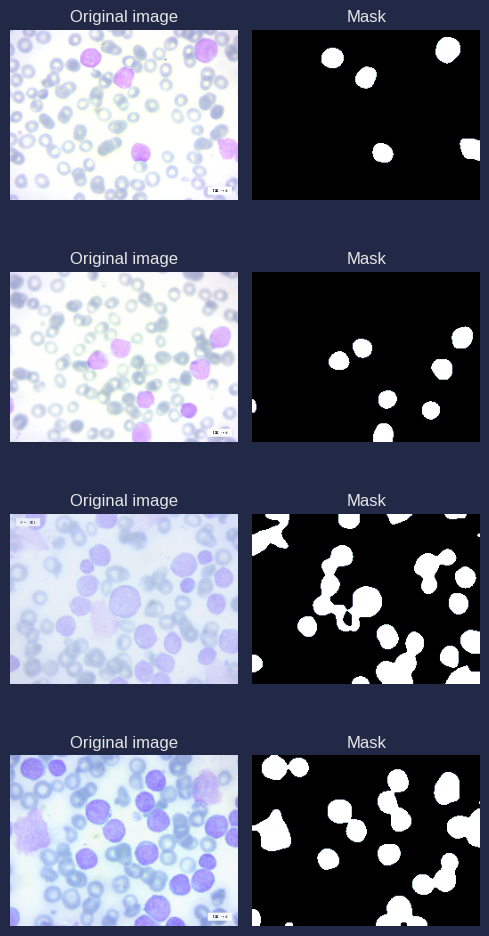

In [47]:
plt.subplots(4, 2, figsize=(5, 10))
for i, (image, mask) in enumerate(train_data_sg_aug.take(1).unbatch()):
    if i == 4:
        break
    plt.subplot(4, 2, (i*2)+1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Original image")
    plt.subplot(4, 2, (i*2)+2)
    plt.imshow(mask, cmap="bone")
    plt.axis("off")
    plt.title(f"Mask")
plt.tight_layout()

## Training a baseline model with data augmentation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


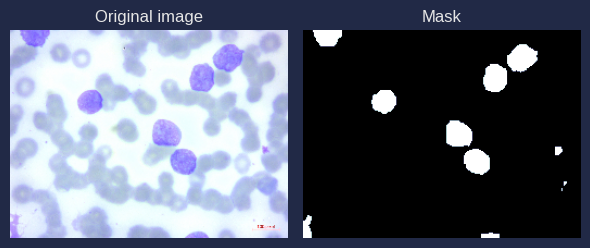


Sample Prediction after epoch 47

70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 271ms/step - binary_accuracy: 0.9832 - binary_io_u: 0.9049 - loss: 0.0901 - val_binary_accuracy: 0.9861 - val_binary_io_u: 0.9333 - val_loss: 0.0770 - learning_rate: 1.0000e-09
Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 39.


In [48]:
model_base_sg_aug = get_model_segmentation()
history_base_sg_aug = train_model_segmentation(model_base_sg_aug, train_data_sg_aug, val_data_sg, epochs=100, version="base_segmentation_aug")

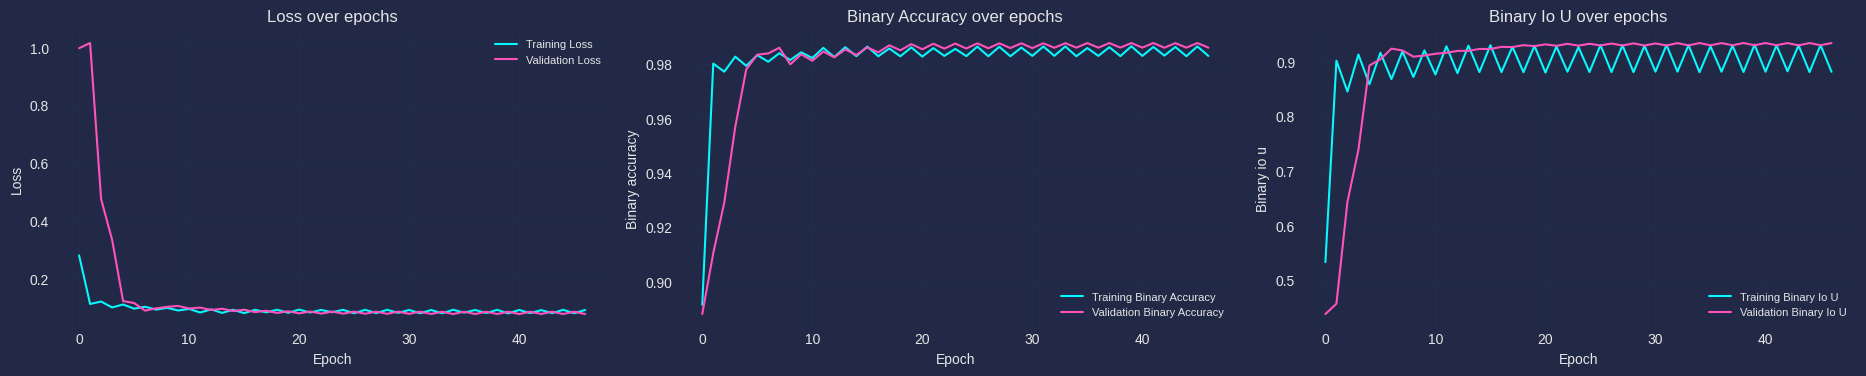

In [49]:
show_history(version="base_segmentation_aug", parameters=[["loss", "val_loss"],
                                                      ["binary_accuracy", "val_binary_accuracy"],
                                                      ["binary_io_u", "val_binary_io_u"]])

## Evaluating the baseline model for image segmentation with data augmentation

In [50]:
result_test_sg_aug = model_base_sg_aug.evaluate(test_data_sg)
result_test_sg_aug

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - binary_accuracy: 0.9843 - binary_io_u: 0.9277 - loss: 0.0838


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


[0.08542630821466446, 0.9245516061782837, 0.9841703176498413]

## Evaluation metrics for segmentation task

In [51]:
for i, (img, mask) in enumerate(test_data_sg):
    aux = tf.reshape(mask,[-1])
    if i == 0:
        y_true = aux.numpy()
    else:
        y_true = np.concatenate((y_true, aux.numpy()), axis=0)

scores = []
for model in [model_base_sg, model_base_sg_aug]:
    y_test_pred_proba = model.predict(test_data_sg, verbose=0)
    y_test_pred_proba = tf.reshape(y_test_pred_proba,[-1])
    y_test_pred = tf.math.round(y_test_pred_proba)
    result_test = model.evaluate(test_data_sg)
    score = get_scores(y_true, y_test_pred, y_test_pred_proba)
    score["BinaryIOU"] = result_test[1]
    score["BinaryAccuracy"] = result_test[2]
    scores.append(score)

comparison = pd.DataFrame(data=scores, index=["Baseline Model", "Baseline Model with DA"], columns=["AUC_ROC", "F1_Score", "Accuracy", "Precision", "Recall", "BinaryIOU", "BinaryAccuracy"])
comparison.style.highlight_max(color = 'green', axis = 0).highlight_min(color = 'red', axis = 0)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - binary_accuracy: 0.9851 - binary_io_u: 0.9295 - loss: 0.0845


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - binary_accuracy: 0.9843 - binary_io_u: 0.9277 - loss: 0.0838


# Image segmentation and classification
## Creating a baseline model for image segmentation and classification

In [52]:
def get_model_both():
    tf.keras.backend.clear_session()
    
    inp = Input(shape=img_shape+(3,))
    seg_output = segmentation_architecture(inp, name_output="segmentation")
    clf_output = classification_w_backbone_architecture(inp, name_output="classification")
    
    model = Model(inputs=inp, outputs={"segmentation":seg_output,
                                       "classification":clf_output})
    
    model.compile(loss={"segmentation":Dice(),
                        "classification":CategoricalCrossentropy()},
                  optimizer=Adam(learning_rate=1e-3),
                  metrics={"segmentation":[BinaryIoU(), BinaryAccuracy()],
                           "classification":[AUC()]}
                 )
    return model

model_base_both = get_model_both()

In [53]:
model_base_both.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 192, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 192, 256, 128)  │          1,664 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 192, 256, 128)  │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 192, 256, 128)  │            512 │ re_lu[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 192, 256, 64)   │         32,832 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 192, 256, 64)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 192, 256, 64)   │            256 │ re_lu_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 96, 128, 64)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 96, 128, 64)    │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 96, 128, 128)   │         32,896 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 96, 128, 128)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 96, 128, 128)   │            512 │ re_lu_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 96, 128, 64)    │         32,832 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 96, 128, 64)    │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 96, 128, 64)    │            256 │ re_lu_3[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 48, 64, 64)     │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)  

 Total params: 15,131,061 (57.72 MB)

 Trainable params: 414,837 (1.58 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

### Let's plot the model

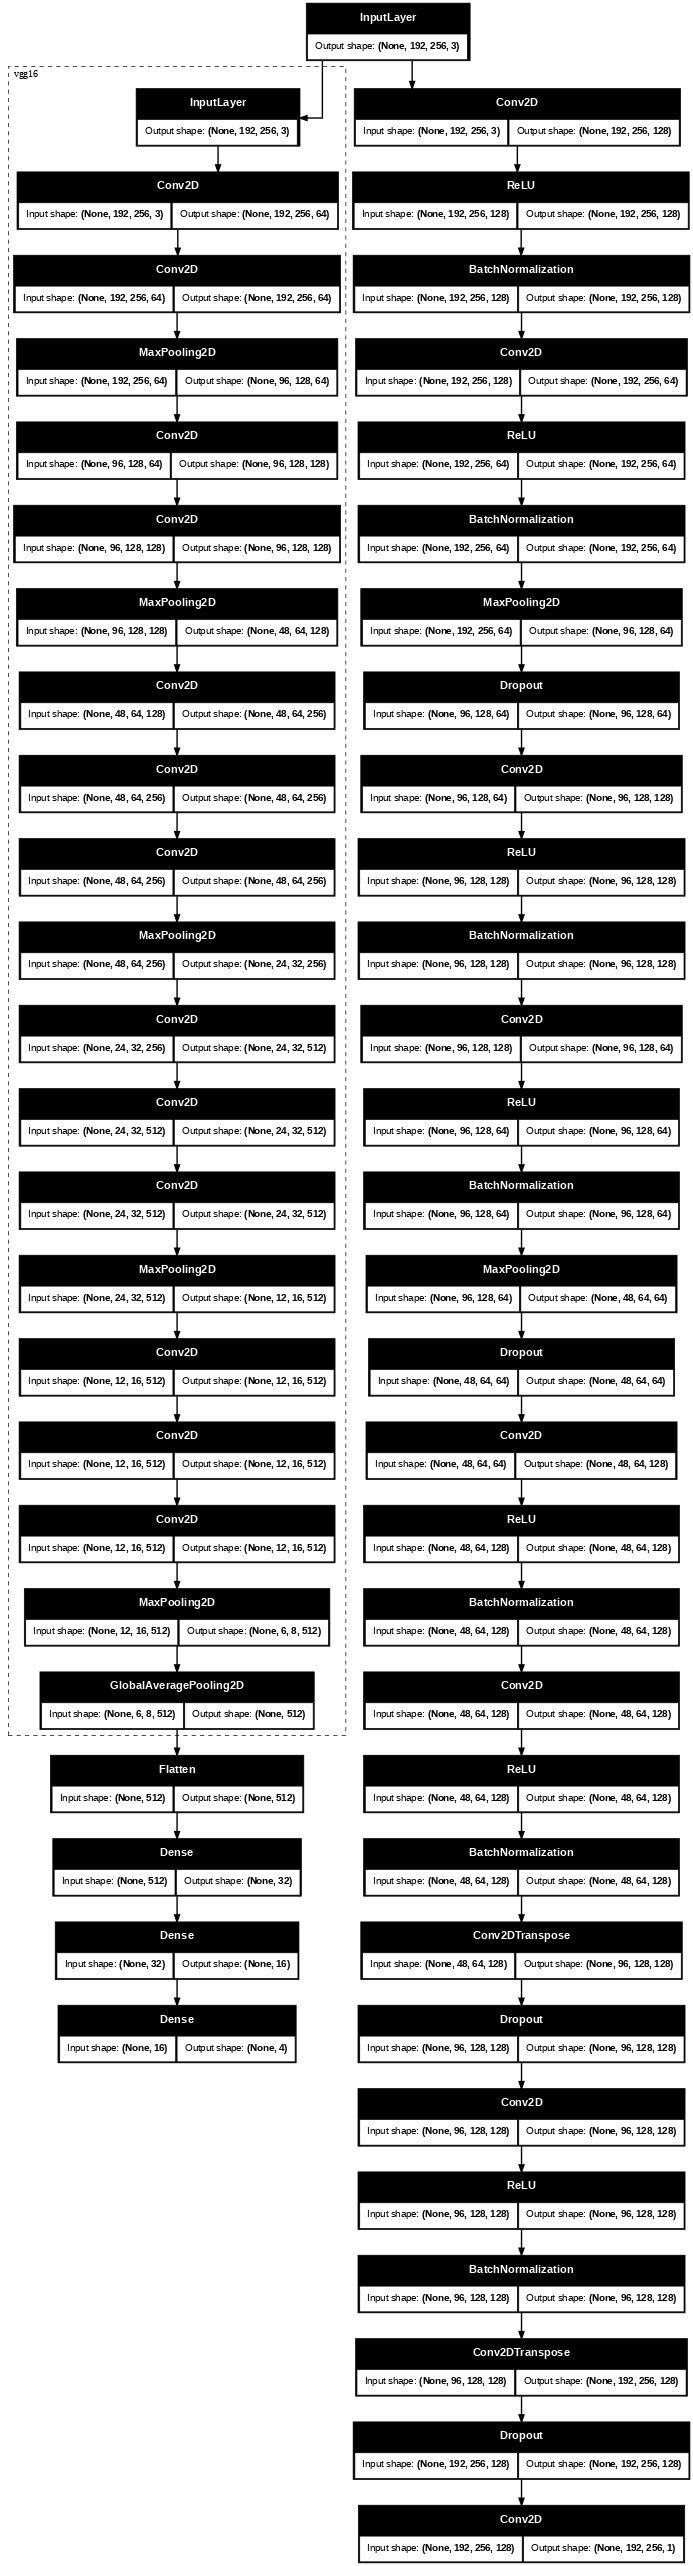

In [54]:
plot_model(model_base_both, expand_nested=True, dpi=50, show_shapes=True)

### Function for display some predictions during the training

In [55]:
def show_predictions(dataset=None):
    for image, _ in dataset.shuffle(100).take(1):
        pred = model_base_both.predict(image)
        pred_mask, pred_class = pred["segmentation"][0], pred["classification"][0]
        pred_mask = pred_mask >= 0.5
        
        plt.subplots(1, 2, figsize=(6, 3))
        
        plt.subplot(1, 2, 1)
        plt.imshow(image[0])
        plt.axis("off")
        plt.title(f"Original image\nClass: {classes[np.argmax(pred_class)]}")
        
        plt.subplot(1, 2, 2)
        plt.imshow(pred_mask, cmap="bone")
        plt.axis("off")
        plt.title(f"Mask\nClass: {classes[np.argmax(pred_class)]}")
        
        plt.tight_layout()
        plt.show()
        break
    return

class DisplayCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(dataset=val_data_sg)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
        return

### Let's train

In [56]:
def train_model_both(model, train_data, val_data, epochs=100, version="base"):
    checkpoint_filepath = f'/kaggle/working/models/model_{version}.keras'
    checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', save_best_only=True)
    early = EarlyStopping(monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
    reduce = ReduceLROnPlateau(monitor='val_loss', patience=3)
    csvlogger = CSVLogger(f"/kaggle/working/histories/history_model_{version}.csv", separator=',')
    
    history = model.fit(train_data,
                      batch_size=batch_size,
                      epochs=epochs,
                      callbacks=[early,
                                 reduce,
                                 checkpoint,
                                 csvlogger,
                                 DisplayCallback()],
                      validation_data=val_data,
                      steps_per_epoch=len(df_train)//batch_size,
                      validation_steps=len(df_val)//batch_size,
                      validation_batch_size=batch_size
                     )
    return history

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


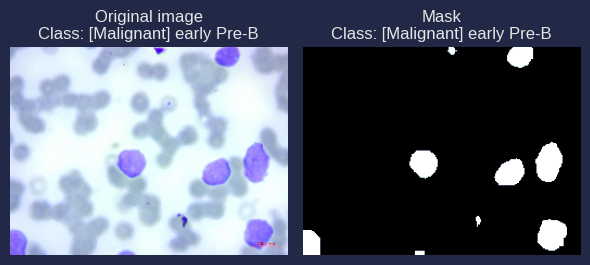


Sample Prediction after epoch 40

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - classification_auc: 1.0000 - loss: 0.0863 - segmentation_binary_accuracy: 0.9904 - segmentation_binary_io_u: 0.9491 - val_classification_auc: 1.0000 - val_loss: 0.0866 - val_segmentation_binary_accuracy: 0.9889 - val_segmentation_binary_io_u: 0.9339 - learning_rate: 1.0000e-05
Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 32.


In [57]:
history_base_both = train_model_both(model_base_both, train_data_both, val_data_both, epochs=100, version="seg_clf")

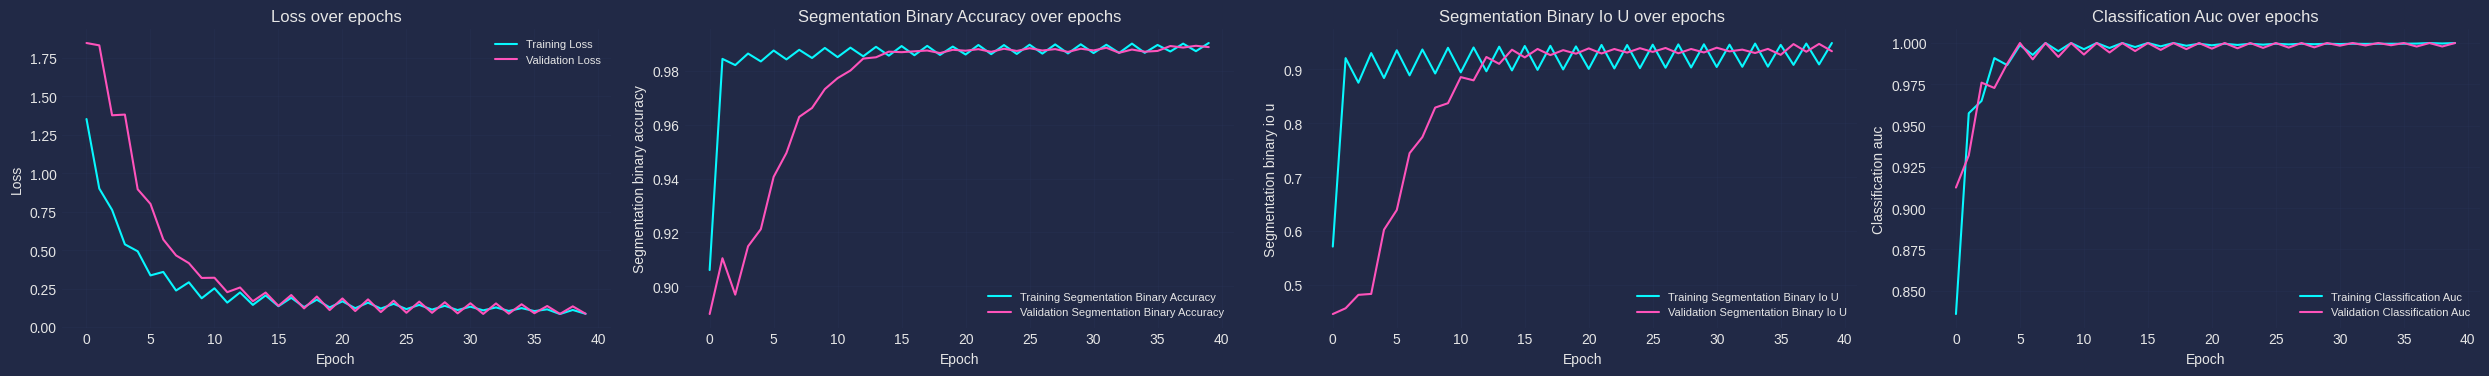

In [58]:
show_history(version="seg_clf", parameters=[["loss", "val_loss"],
                                            ["segmentation_binary_accuracy", "val_segmentation_binary_accuracy"],
                                            ["segmentation_binary_io_u", "val_segmentation_binary_io_u"],
                                            ["classification_auc", "val_classification_auc"]])

## Evaluating the baseline model for image segmentation and classification

In [59]:
model_base_both.evaluate(test_data_both, return_dict=True)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - classification_auc: 0.9989 - loss: 0.1587 - segmentation_binary_accuracy: 0.9861 - segmentation_binary_io_u: 0.9357


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


{'classification_auc': 0.998967707157135,
 'loss': 0.15506461262702942,
 'segmentation_binary_accuracy': 0.9860495924949646,
 'segmentation_binary_io_u': 0.9328948259353638}

## Applying data augmentation technique

In [60]:
def data_transformation_both(image, mask, class_):
    img = random_brightness(image, max_delta=0.01, seed=seed_value)
    img = random_contrast(img, lower=0.5, upper=1, seed=seed_value)
    img = random_saturation(img, lower=0.5, upper=1, seed=seed_value)
    aux = tf.concat([img, mask], -1)
    
    aux_ = random_flip_left_right(aux, seed=seed_value)
    aux_ = random_flip_up_down(aux_, seed=seed_value)
    
    class_ohe = tf.one_hot(indices=tf.squeeze(class_, axis=0), depth=4)

    return tf.cast(aux_[..., :3], tf.float32)/255, {"segmentation":tf.cast(aux_[..., 3:], tf.float32)/255, "classification":tf.cast(class_ohe, tf.float32)}

train_data_both_aug = train_data.map(data_transformation_both, num_parallel_calls=autotune)
train_data_both_aug = train_data_both_aug.batch(batch_size)
train_data_both_aug = train_data_both_aug.prefetch(autotune)

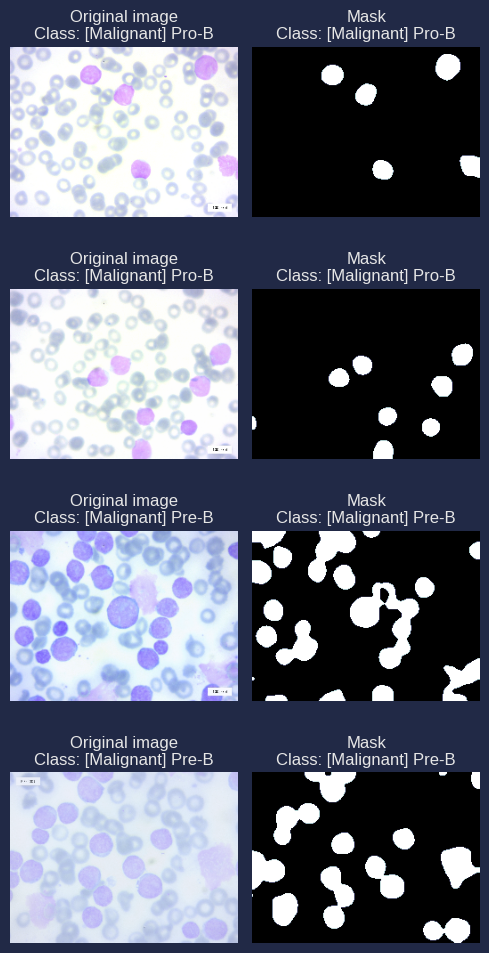

In [61]:
plt.subplots(4, 2, figsize=(5, 10))
for i, (image, pred) in enumerate(train_data_both_aug.take(1).unbatch()):
    mask, class_ = pred["segmentation"], pred["classification"]
    if i == 4:
        break
    plt.subplot(4, 2, (i*2)+1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Original image\nClass: {classes[np.argmax(class_)]}")
    
    plt.subplot(4, 2, (i*2)+2)
    plt.imshow(mask, cmap="bone")
    plt.axis("off")
    plt.title(f"Mask\nClass: {classes[np.argmax(class_)]}")
plt.tight_layout()

## Let's train

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


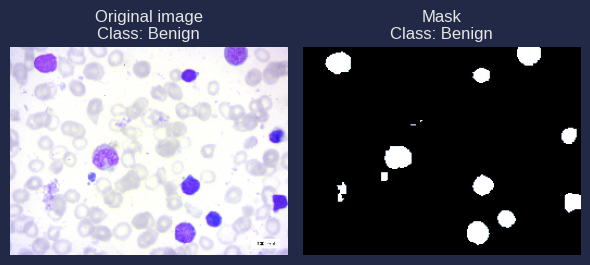


Sample Prediction after epoch 62

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - classification_auc: 1.0000 - loss: 0.1346 - segmentation_binary_accuracy: 0.9883 - segmentation_binary_io_u: 0.9388 - val_classification_auc: 1.0000 - val_loss: 0.1537 - val_segmentation_binary_accuracy: 0.9885 - val_segmentation_binary_io_u: 0.9332 - learning_rate: 1.0000e-06
Epoch 62: early stopping
Restoring model weights from the end of the best epoch: 54.


In [62]:
model_base_both_aug = get_model_both()
history_base_both_aug = train_model_both(model_base_both_aug, train_data_both_aug, val_data_both, epochs=100, version="seg_clf_aug")

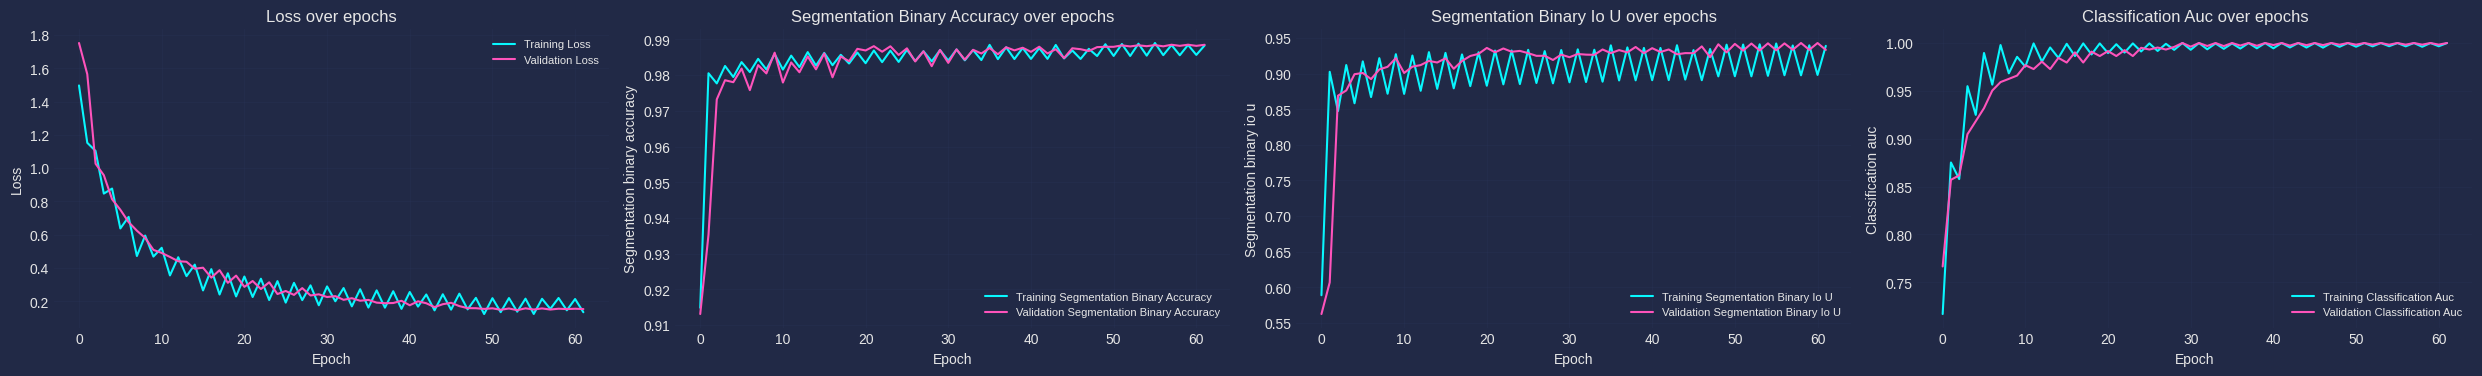

In [63]:
show_history(version="seg_clf_aug", parameters=[["loss", "val_loss"],
                                            ["segmentation_binary_accuracy", "val_segmentation_binary_accuracy"],
                                            ["segmentation_binary_io_u", "val_segmentation_binary_io_u"],
                                            ["classification_auc", "val_classification_auc"]])

## Evaluating the baseline model for image segmentation and classification with DA

In [64]:
model_base_both_aug.evaluate(test_data_both, return_dict=True)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - classification_auc: 0.9950 - loss: 0.2075 - segmentation_binary_accuracy: 0.9861 - segmentation_binary_io_u: 0.9356


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


{'classification_auc': 0.9952672123908997,
 'loss': 0.20352022349834442,
 'segmentation_binary_accuracy': 0.9860218167304993,
 'segmentation_binary_io_u': 0.932688295841217}

## Evaluation metrics for both tasks

In [65]:
for i, (img, output) in enumerate(test_data_both):
    mask, class_ = output["segmentation"], output["classification"]
    aux = tf.reshape(mask,[-1])
    if i == 0:
        y_true_class = class_.numpy()
        y_true_mask = aux.numpy()
    else:
        y_true_class = np.concatenate((y_true_class, class_.numpy()), axis=0)
        y_true_mask = np.concatenate((y_true_mask, aux.numpy()), axis=0)
        
scores_mask = []
scores_class = []
for model in [model_base_both, model_base_both_aug]:
    y_test_pred_proba = model.predict(test_data_both, verbose=0)
    
    y_test_pred_proba_class = y_test_pred_proba["classification"]
    y_test_pred_class = tf.math.round(y_test_pred_proba_class)
    scores_class.append(get_scores(y_true_class, y_test_pred_class, y_test_pred_proba_class))
    
    y_test_pred_proba_mask = y_test_pred_proba["segmentation"]
    y_test_pred_proba_mask = tf.reshape(y_test_pred_proba_mask,[-1])
    y_test_pred_mask = tf.math.round(y_test_pred_proba_mask)
    score = get_scores(y_true_mask, y_test_pred_mask, y_test_pred_proba_mask)
    result_test = model.evaluate(test_data_both, return_dict=True)
    score["BinaryIOU"] = result_test["segmentation_binary_io_u"]
    score["BinaryAccuracy"] = result_test["segmentation_binary_accuracy"]
    scores_mask.append(score)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - classification_auc: 0.9989 - loss: 0.1587 - segmentation_binary_accuracy: 0.9861 - segmentation_binary_io_u: 0.9357


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - classification_auc: 0.9950 - loss: 0.2075 - segmentation_binary_accuracy: 0.9861 - segmentation_binary_io_u: 0.9356


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


### For classification task

In [66]:
comparison = pd.DataFrame(data=scores_class, index=["Baseline Model", "Baseline Model with DA"], columns=["AUC_ROC", "F1_Score", "Accuracy", "Precision", "Recall"])
comparison.style.highlight_max(color = 'green', axis = 0).highlight_min(color = 'red', axis = 0)

### For segmentation task

In [67]:
comparison = pd.DataFrame(data=scores_mask, index=["Baseline Model", "Baseline Model with DA"], columns=["AUC_ROC", "F1_Score", "Accuracy", "Precision", "Recall", "BinaryIOU", "BinaryAccuracy"])
comparison.style.highlight_max(color = 'green', axis = 0).highlight_min(color = 'red', axis = 0)

## Confusion Matrix for classification

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


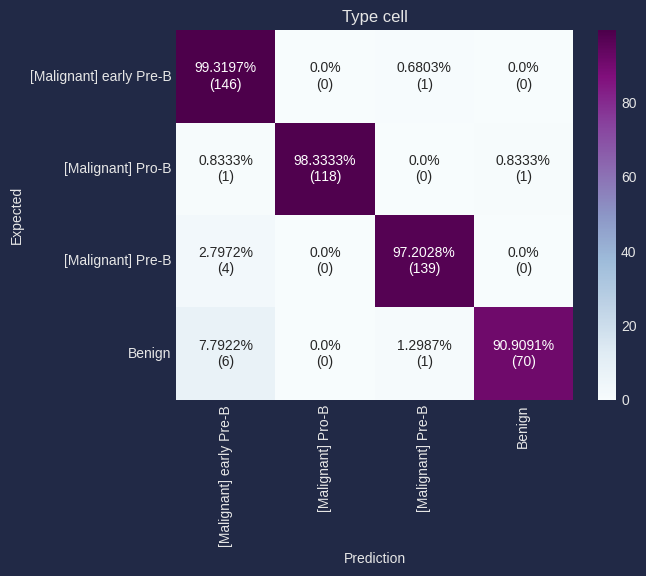

In [81]:
for i, (img, output) in enumerate(test_data_both):
    class_ = tf.argmax(output["classification"], axis=1)
    if i == 0:
        y_true = class_.numpy()
    else:
        y_true = np.concatenate((y_true, class_.numpy()), axis=0)
        
y_test_pred_proba = model_base_both.predict(test_data_both, verbose=0)
y_test_pred_proba = y_test_pred_proba["classification"]
y_test_pred = tf.argmax(y_test_pred_proba, axis=1)

def my_cm(y_true, y_pred, title):
    cm_val = confusion_matrix(y_true, y_pred)
    cm_pgs = np.round(confusion_matrix(y_true, y_pred, normalize='true')*100, 4)

    formatted_text = (np.asarray([f"{pgs}%\n({val})" for val, pgs in zip(cm_val.flatten(), cm_pgs.flatten())])).reshape(4, 4)

    sns.heatmap(cm_pgs, annot=formatted_text, fmt='', cmap='BuPu', yticklabels=classes, xticklabels=classes)
    plt.title(title)
    plt.xlabel("Prediction")
    plt.ylabel("Expected")
    return
    
my_cm(y_true, y_test_pred, title="Type cell")

# Let's take a look at the predictions.

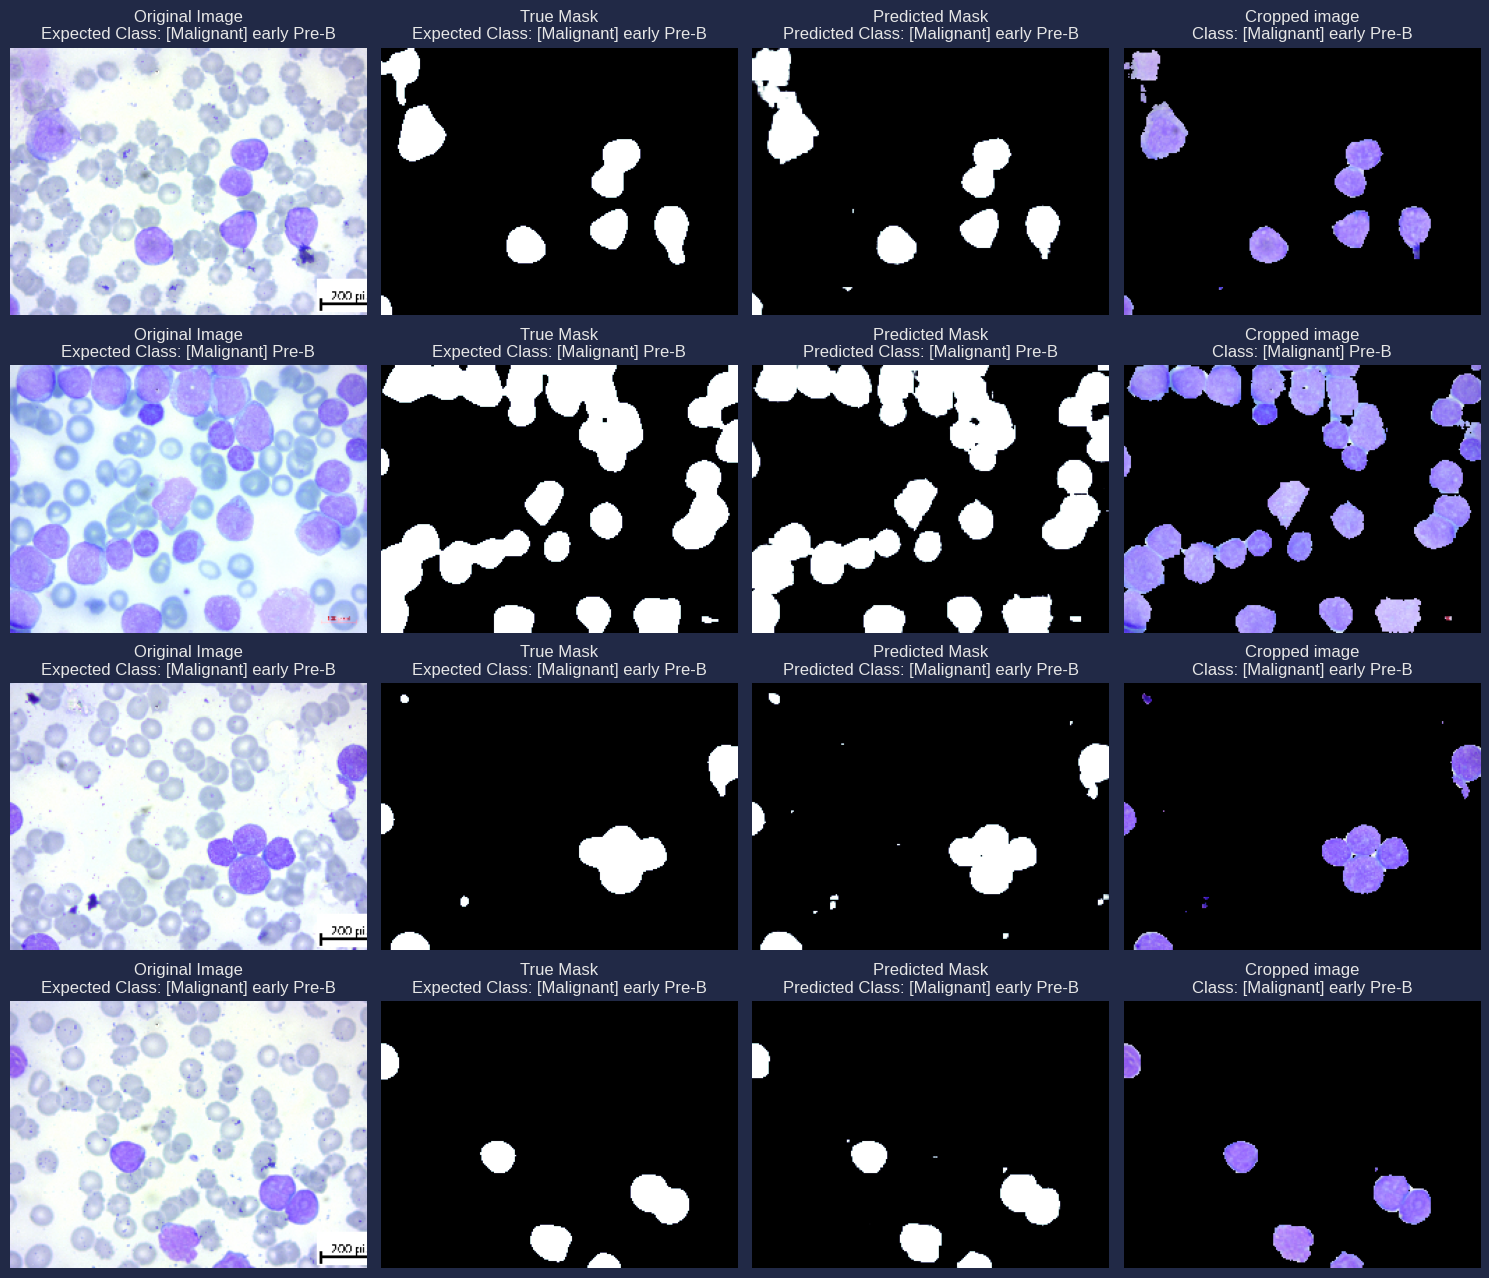

In [119]:
plt.subplots(4, 4, figsize=(15, 13))
for i, (image, output) in enumerate(test_data_both.shuffle(100).take(1).unbatch()):
    if i == 4:
        break
        
    pred = model_base_both.predict(tf.expand_dims(image, axis=0), verbose=0)
    
    class_ = np.argmax(output["classification"])
    pred_class_proba = pred["classification"]
    pred_class = tf.argmax(pred_class_proba, axis=1)

    mask = output["segmentation"]
    pred_mask = tf.squeeze(pred["segmentation"], axis=0)
    image_cropped = apply_mask(tf.cast(image*255, tf.uint8).numpy(), tf.cast(pred_mask, tf.uint8).numpy())
    
    plt.subplot(4, 4, (i*4)+1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Original Image\nExpected Class: {classes[class_]}")

    plt.subplot(4, 4, (i*4)+2)
    plt.imshow(mask, cmap="bone")
    plt.axis("off")
    plt.title(f"True Mask\nExpected Class: {classes[class_]}")

    plt.subplot(4, 4, (i*4)+3)
    plt.imshow(pred_mask, cmap="bone")
    plt.axis("off")
    plt.title(f"Predicted Mask\nPredicted Class: {classes[int(pred_class)]}")

    plt.subplot(4, 4, (i*4)+4)
    plt.imshow(image_cropped)
    plt.axis("off")
    plt.title(f"Cropped image\nClass: {classes[int(pred_class)]}")

plt.tight_layout()

# Thank you for your time! 😃